# TITANIC DATASET ANALYSIS

#### Import necessary libraries

In [14]:
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, recall_score, precision_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.ensemble import GradientBoostingClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import AllKNN


#### Load the dataset into a dataframe

In [15]:
data = pd.read_csv('titanic.csv')
data.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.00,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.92,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.00,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.00,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.00,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


#### Data description

We can use the `describe()` method to get a summary of the numerical attributes of the dataset. This will help us to understand the data better.

In [16]:
data.describe()

,pclass,survived,age,sibsp,parch,fare,body
count,1309.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000,121.000000
mean,2.294882,0.381971,29.881138,0.498854,0.385027,33.295479,160.809917
std,0.837836,0.486055,14.413493,1.041658,0.865560,51.758668,97.696922
min,1.000000,0.000000,0.170000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,21.000000,0.000000,0.000000,7.895800,72.000000
50%,3.000000,0.000000,28.000000,0.000000,0.000000,14.454200,155.000000
75%,3.000000,1.000000,39.000000,1.000000,0.000000,31.275000,256.000000
max,3.000000,1.000000,80.000000,8.000000,9.000000,512.329200,328.000000


The `info()` method will give us a concise summary of the dataframe, including the number of non-null values in each column as well as the data type of each column.

In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pclass     1309 non-null   int64  
 1   survived   1309 non-null   int64  
 2   name       1309 non-null   object 
 3   sex        1309 non-null   object 
 4   age        1046 non-null   float64
 5   sibsp      1309 non-null   int64  
 6   parch      1309 non-null   int64  
 7   ticket     1309 non-null   object 
 8   fare       1308 non-null   float64
 9   cabin      295 non-null    object 
 10  embarked   1307 non-null   object 
 11  boat       486 non-null    object 
 12  body       121 non-null    float64
 13  home.dest  745 non-null    object 
dtypes: float64(3), int64(4), object(7)
memory usage: 143.3+ KB


In order to understand what features we may have to clean, as there might be missing values, we can use the code below to get the percentage of NaN values in each column.

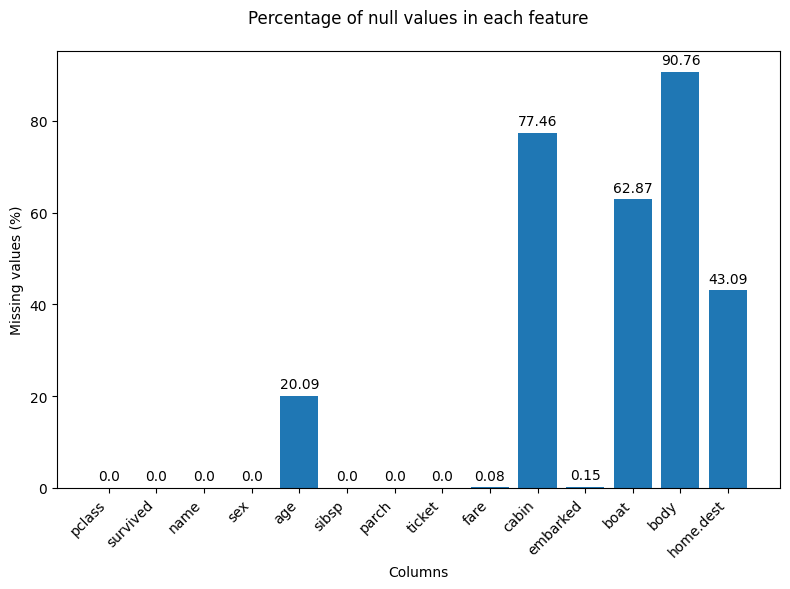

In [18]:
# Calculate the percentage of missing values in each column
missing_data = data.isna().sum() / len(data) * 100

# Create a bar graph
plt.figure(figsize=(8, 6))
bars = plt.bar(missing_data.index, missing_data.values)
plt.title('Percentage of null values in each feature', pad=20)
plt.xlabel('Columns')
plt.ylabel('Missing values (%)')

plt.xticks(rotation=45, ha='right')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, round(yval, 2), ha='center', va='bottom')

plt.tight_layout()
plt.show()

##### NaN values
Upon reviewing the dataset, we noted a significant number of NaN values in the `body`, `boat`, and `cabin` columns. Given their high percentage of NaN values, we decided to drop these columns as they wouldn't contribute meaningfully to our analysis. Although the `age`, `home.dest`, `embarked` and `fare` columns also contained some missing data, falling under 50%, we needed to think how we would handle them. We resolved to drop the `home.dest` column due to its limited relevance to our analysis. For the `age` column we thought of filling those values with the mean of the column but for a more filtered approach we decided to fill the missing values with the mean of the ages of the passengers in the same class. In the `embarked` column, we addressed missing values by substituting them with the column's most frequent value and similarly to the `age` feature, for the `fare` column, we replaced missing entries with the column's mean value.

##### Data cleaning
After addressing the features with a significat percentage of NaN values, we turned our attention to the other columns. Upon consideration, we determined that the `name` column served no significant purpose for our analysis decideding to drop it. Similarly, we chose to remove the `ticket` column as it merely serves as a unique identifier for each passenger and does not offer valuable insights. Additionally, recognizing the presence of categorical features, we proceeded to convert them into numerical values using the `get_dummies()` method. Specifically, the `sex` and `embarked` columns were converted into multiple boolean columns. For the `sex` column, it created two new columns: `sex_male` and `sex_female`, where a `true` represents the presence of that category and a `false` represents the absence. Similarly, for the `embarked` column, it created three new columns: `embarked_C`, `embarked_Q`, and `embarked_S`, each representing one of the original categories.

In [19]:
# Changing the Nan values in the age column to the mean of the age of the respective class
data['age'] = data.groupby('pclass')['age'].transform(lambda x: x.fillna(x.mean()))

# Changing the Nan values in the fare column to the mean
data['fare'] = data['fare'].fillna(data['fare'].dropna().mean())

# Changing the Nan values in the embarked column to the mode
data['embarked'] = data['embarked'].fillna(data['embarked'].dropna().mode()[0])

# Dropping the body, boat, cabin and home.dest columns
processed_data = data.drop([
    'boat', 
    'body', 
    'cabin', 
    'home.dest',
    'name',
    'ticket'
], axis=1) 


processed_data = pd.get_dummies(processed_data)
processed_data.head()




,pclass,survived,age,sibsp,parch,fare,sex_female,sex_male,embarked_C,embarked_Q,embarked_S
0,1,1,29.00,0,0,211.3375,True,False,False,False,True
1,1,1,0.92,1,2,151.5500,False,True,False,False,True
2,1,0,2.00,1,2,151.5500,True,False,False,False,True
3,1,0,30.00,1,2,151.5500,False,True,False,False,True
4,1,0,25.00,1,2,151.5500,True,False,False,False,True


Although the dataset was basically clean, we still made some changes. We needed to drop one of `sex_male` and `sex_female` columns to avoid multicollinearity as they are inversely related and we also decided to merge `sibsp` and `parch` columns into a single column called `family` that represents the number of family members on board. Similarly, with the `sex_male` and `sex_female` columns, we dropped one of the `embarked_C`, `embarked_Q`, and `embarked_S` columns to avoid multicollinearity.

We can test if we can remove the `embarked` column by checking if there is any case where all the values of the 'embarked' columns are `False` . If there is, we cannot remove the columns, since it means we cannot predict the value of the dropped column from the other columns.

In [20]:
mask = (processed_data['embarked_C'] == False) & (processed_data['embarked_Q'] == False) & (processed_data['embarked_S'] == False)
rows_with_all_false = processed_data[mask]

if not rows_with_all_false.empty:
    print("Exists rows where all columns are False.")
else:
    print("There are no rows where all columns are False.")

There are no rows where all columns are False.


Since there are no rows where all columns are False, we can safely drop one of the columns. If both `embarked_S` and `embarked_Q` are `False`, then `embarked_C` is `True`. So we can drop `embarked_C` column.

Finally, since we will merge `sibsp` and `parch` columns into a single column called `family`, we can drop the `sibsp` and `parch` columns.

In [21]:
processed_data['family'] = processed_data['sibsp'] + processed_data['parch']

processed_data = processed_data.drop([
    'sex_male',
    'sibsp',
    'parch',
    'embarked_C'
], axis=1)


processed_data.head()


,pclass,survived,age,fare,sex_female,embarked_Q,embarked_S,family
0,1,1,29.00,211.3375,True,False,True,0
1,1,1,0.92,151.5500,False,False,True,3
2,1,0,2.00,151.5500,True,False,True,3
3,1,0,30.00,151.5500,False,False,True,3
4,1,0,25.00,151.5500,True,False,True,3


So in order to understand how those features are related to the survival rate, we ploted a graph to show how the features are distributaded based on the survival rate.

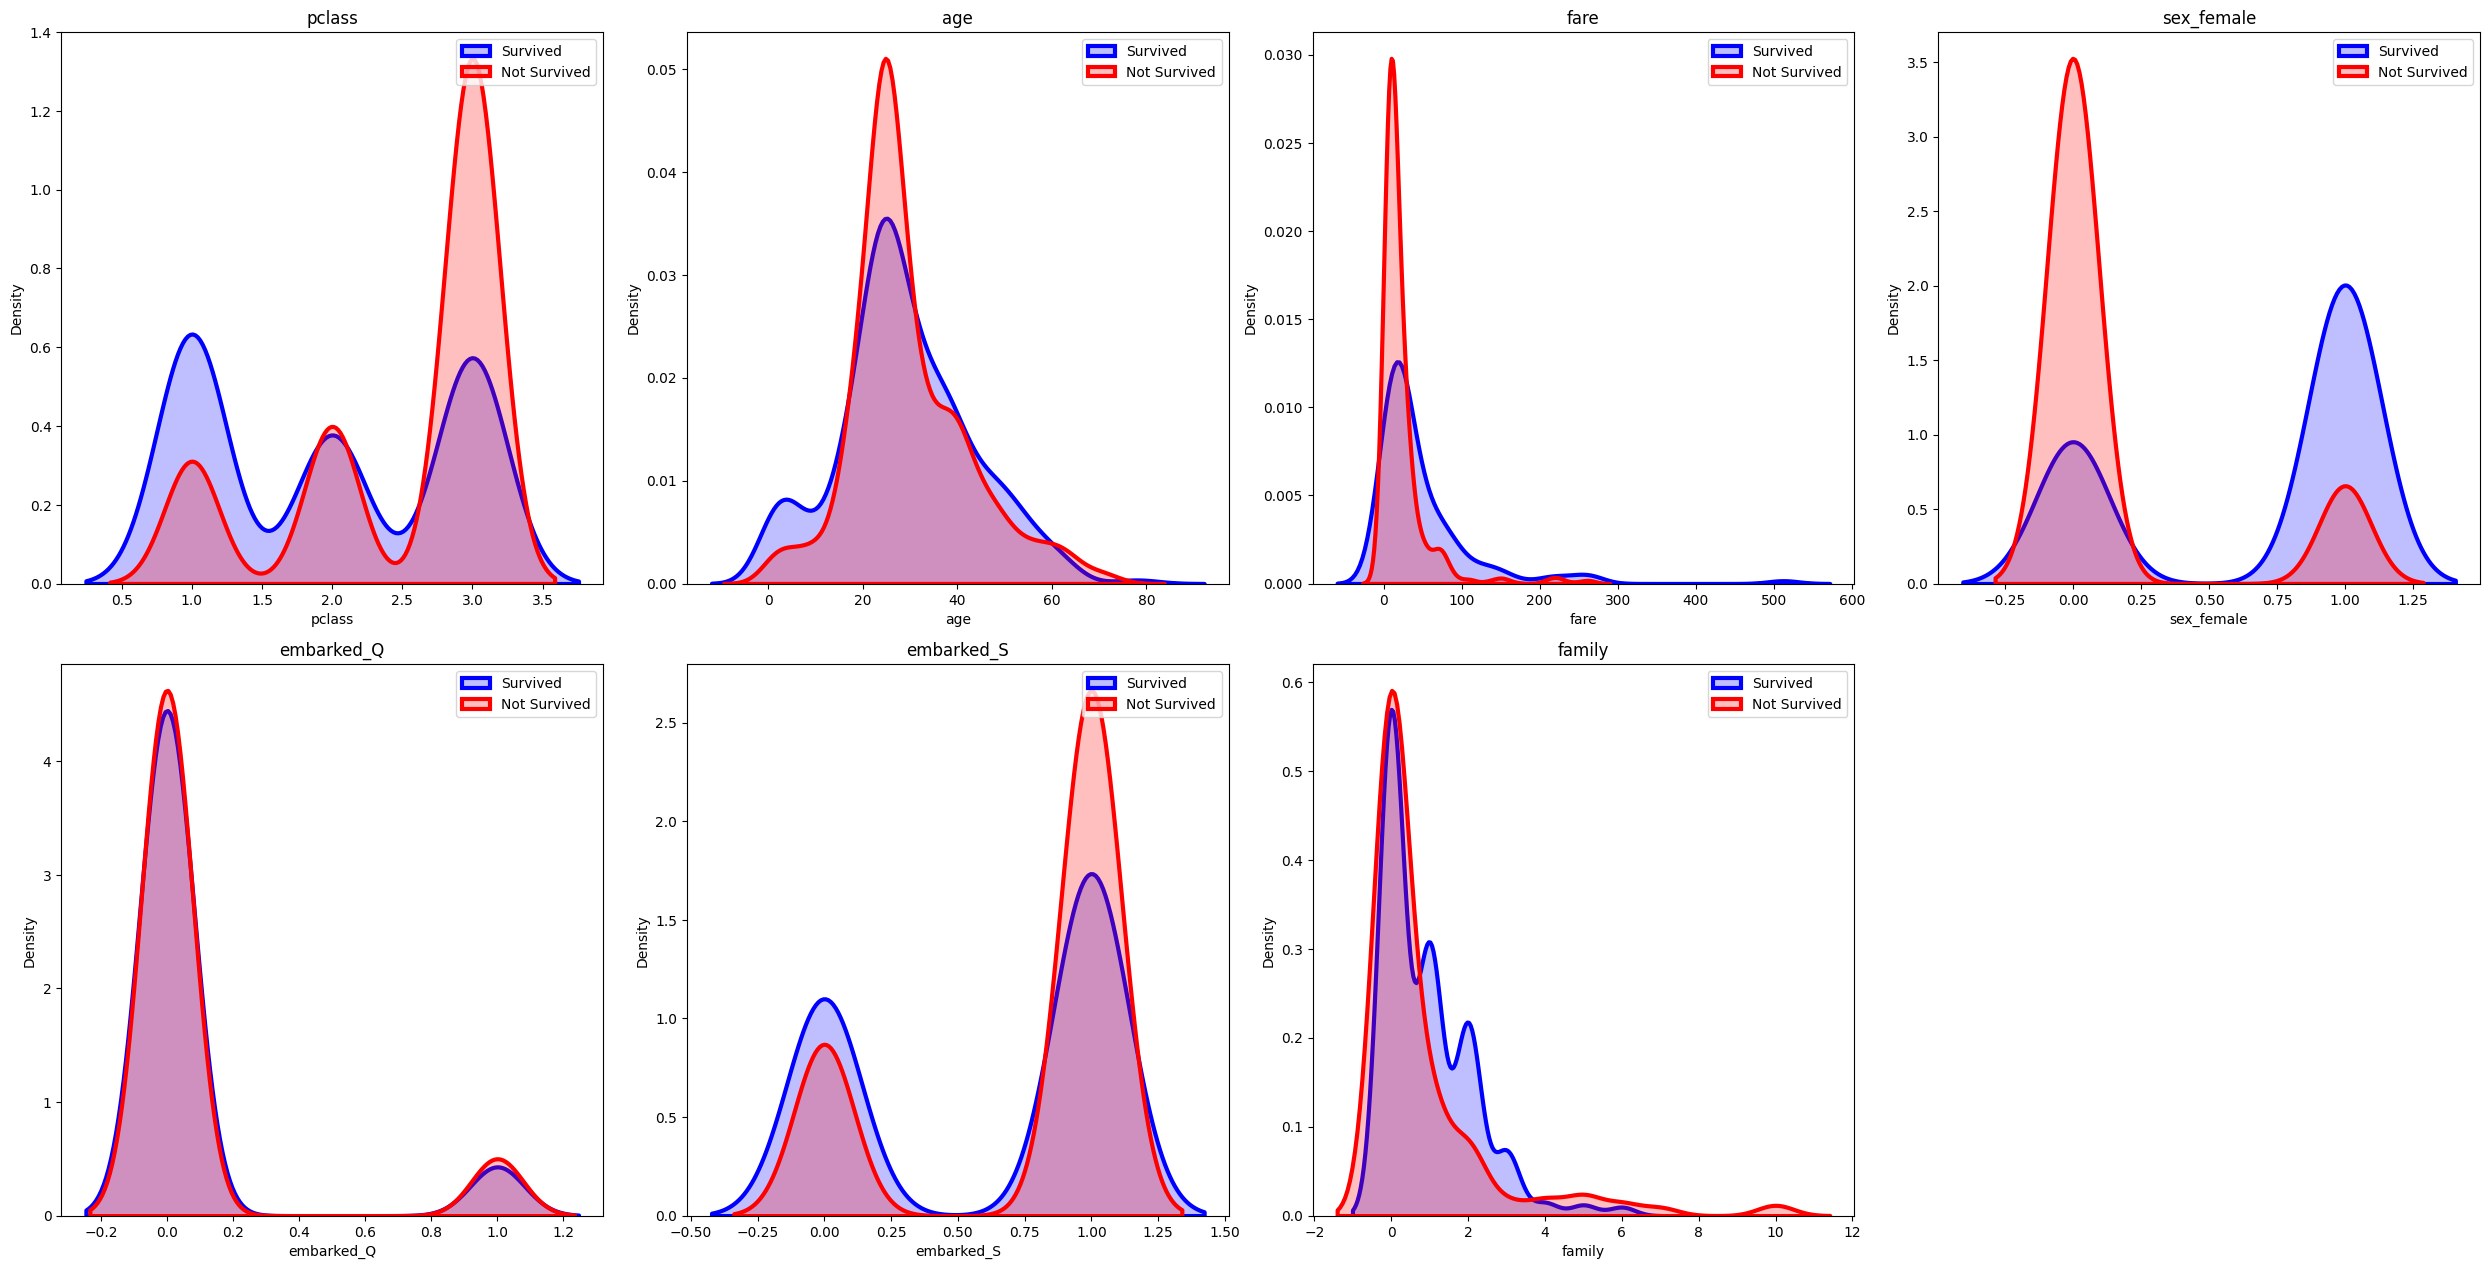

In [22]:
plt.figure(figsize=(25,25))
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)

# Create dataframes for survived and not survived
pd1 = processed_data[processed_data['survived']==1].drop(['survived'],axis=1)
pd2 = processed_data[processed_data['survived']==0].drop(['survived'],axis=1)

for i, col in enumerate(list(pd1.columns)):
    plt.subplot(4, 4, i+1)
    
    # Use seaborn kdeplot which allows you to draw a line at the mean
    sb.kdeplot(pd1[col], fill=True, linewidth=3, color='blue', label='Survived')
    sb.kdeplot(pd2[col], fill=True, linewidth=3, color='red', label='Not Survived')
    
    plt.legend(prop={'size': 10})
    plt.title(col)

plt.tight_layout()
plt.show()

Now to verify numerically the correlation between the features and the survival rate, we used the `corr()` method to calculate the correlation between the features and the target variable. We then plotted a heatmap to visualize the correlation between the features and the target variable.

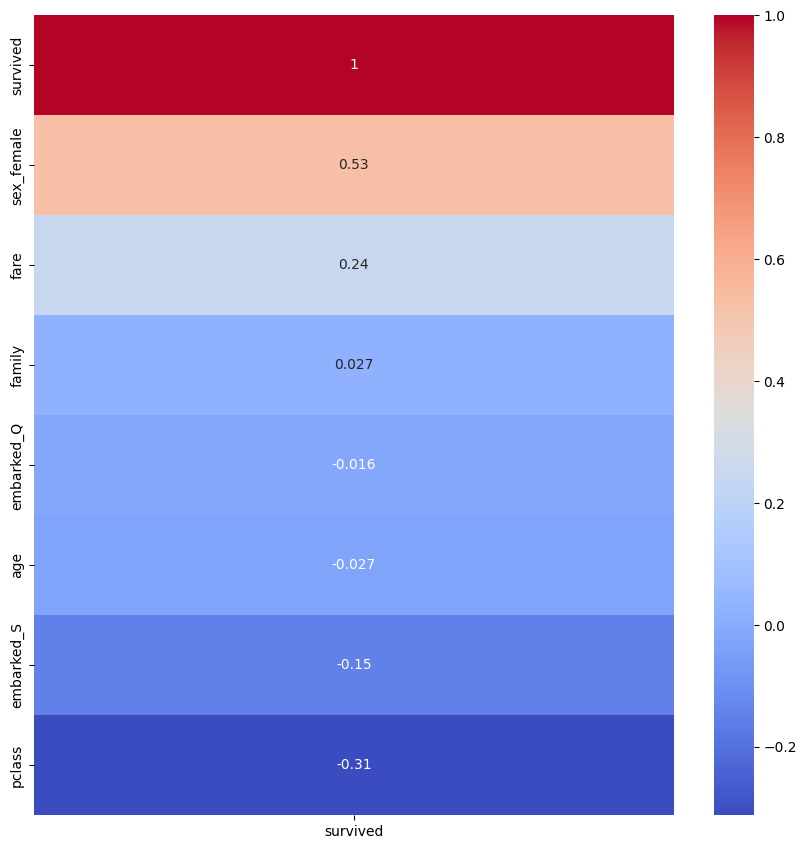

In [23]:
cols = list(processed_data.columns)
plt.figure(figsize=(10,10))
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)

corr = processed_data.corr()[['survived']].sort_values(by='survived', ascending=False)
sb.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

The heatmap made above show the correlation, numerically, between the features and the target variable. A positive value indicates that when the feature increases, the target variable also increases. A negative value indicates that when the feature increases, the target variable decreases. A value of 0 indicates no correlation between the feature and the target variable.

Analyzing the heatmap and and the graphs above, we can check that:  

- The `survived` column is obviously correlated with itself, so it has a correlation of 1. 
- As expected, the `sex_female` column has a high positive correlation with the `survived` column, indicating that women were more likely to survive. This confirms that women were prioritized during the evacuation. In the graphs we can also check that there are a lot of dead men, a number about seven times bigger than the number of dead women; 
- The `fare` column has a high correlation with the `survived` column, indicating that people who paid more for the ticket were more likely to survive. This was not expected, but it is possible that people who paid more for the ticket were in a better location in the ship, which could have helped them to survive. In the graphs we can even confirm that there wasn't a single death for people who paid more than 300 for the ticket.
- The `pclass` column has a high negative correlation with the `survived` column. This indicates that people in the first class were more likely to survive. However, in the graphs we can observe that the number of people who survived in all classes is very similar. The number of people who died in the third class is a lot bigger than the number of people who died in the first and second class, but this can be explained by the fact that there were more people in the third class than in the other classes.
- The other columns have a low correlation with the `survived` column, indicating that they don't have a significant impact on the survival rate. 
- It's curious that the correlation with the `embarked_Q` column and the `embarked_S` column are different. Both have negative correlation with the `survived` column, but the `embarked_Q` column has a higher correlation than the `embarked_S` column. This is interesting because the number of people who embarked in `Q` is a lot smaller than the number of people who embarked in `S`. This could indicate that people who embarked in `Q` were more likely to die than people who embarked in `S`. 
- Another interesting point is that the `family` column has a close to zero correlation with the `survived` column, indicating that the number of family members on board doesn't have a significant impact on the survival rate. However, by visualizing the graphs it is understandable that people with a family size bigger than 4 were more likely to not survive. All families with 7 or more members have died.

## Data analysis

In [24]:
# Splitting the data into features and target
X = processed_data.drop('survived', axis=1)
y = processed_data['survived']

##### Train-test split



In [25]:
unique, counts = np.unique(y, return_counts=True)
result = dict(zip(unique, counts))
print(result)

{0: 809, 1: 500}


In order to split the data into training data and testing data we used the `train_test_split()` method from the `sklearn.model_selection` module to split the data into 80% training and 20% testing sets. This allowed us to train our model on the training set and evaluate its performance on the testing set. We defined `random_state = 42` to ensure reproducibility of the results.

Considering our dataset is quite unbalanced, having 62% of the people not surviving, we decided to test the models with various approaches. Those were:

- `Stratified sampling`: This involves splitting the dataset into training and testing sets while maintaining the same class distribution in both sets. We used the `stratify` parameter in the `train_test_split()` method to perform stratified sampling.

- `Oversampling`: This involves increasing the number of instances in the minority class by randomly replicating them in order to present a higher representation of the minority class in the dataset. We used `SMOTE` from the `imblearn.over_sampling` module to perform oversampling;

- `Undersampling`: This involves reducing the number of instances in the majority class by randomly removing instances in order to present a more balanced representation of the classes in the dataset. We used `AllKNN` from the `imblearn.under_sampling` module to perform undersampling. This method works by removing samples from the majority class that have at least 1 nearest neighbor in the minority class;

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Sample with stratification
X_trainStrt, X_testStrt, y_trainStrt, y_testStrt = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Sampling with SMOTE
smote = SMOTE()
X_trainSmote, y_trainSmote = smote.fit_resample(X_train, y_train)
X_trainSmote, X_testSmote, y_trainSmote, y_testSmote = train_test_split(X_trainSmote, y_trainSmote, test_size=0.2, random_state=42)


# Sampling with AllKNN
allknn = AllKNN()
X_trainAllKNN, y_trainAllKNN = allknn.fit_resample(X_train, y_train)
X_trainAllKNN, X_testAllKNN, y_trainAllKNN, y_testAllKNN = train_test_split(X_trainAllKNN, y_trainAllKNN, test_size=0.2, random_state=42)

To ease our analysis, we calculated the average `accuracy` for each model using the different balancing approaches. While this metric can be a simplistic and sometimes inadequate for evaluating model performance, we deemed it sufficiently descriptive for this comparison.

In [27]:
models = [
    ('Logistic Regression', LogisticRegression(max_iter=1000, random_state=42)),
    ('Decision Tree', DecisionTreeClassifier(random_state=42)),
    ('Random Forest', RandomForestClassifier(random_state=42)),
    ('Extra Trees', ExtraTreesClassifier(random_state=42)),
    ('MLP', MLPClassifier(random_state=42, max_iter=1000)),
    ('KNN', KNeighborsClassifier()),
    ('SVM', SVC(random_state=42)),
    ('Gaussian Naive Bayes', GaussianNB()),
    ('Multinomial Naive Bayes', MultinomialNB()),
    ('Bernoulli Naive Bayes', BernoulliNB()),
    ('Gradient Boosting', GradientBoostingClassifier(random_state=42))
]

sampling_techniques = {
    'Stratified': (X_trainStrt, X_testStrt, y_trainStrt, y_testStrt),
    'SMOTE': (X_trainSmote, X_testSmote, y_trainSmote, y_testSmote),
    'AllKNN': (X_trainAllKNN, X_testAllKNN, y_trainAllKNN, y_testAllKNN)
}

results = []

for sampling_name, (X_tr, X_t, y_tr, y_t) in sampling_techniques.items():
    for model_name, model in models:
        model.fit(X_tr, y_tr)
        y_pred = model.predict(X_t)
        accuracy = accuracy_score(y_t, y_pred)
        results.append((sampling_name, model_name, accuracy))

results_df = pd.DataFrame(results, columns=['Sampling Technique', 'Model', 'Accuracy'])

pivot_df = results_df.pivot(index='Model', columns='Sampling Technique', values='Accuracy')

display(pivot_df)

mean_accuracy = results_df.groupby('Sampling Technique')['Accuracy'].mean()

styled_mean_accuracy = mean_accuracy.sort_values(ascending=False).to_frame().style.background_gradient(cmap='viridis').highlight_max(color='lightgreen')

display(styled_mean_accuracy)

best_approach = mean_accuracy.idxmax()
print(f'The best balancing approach using accuracy as the metric is {best_approach}.')


Sampling Technique,AllKNN,SMOTE,Stratified
Model,,,
Bernoulli Naive Bayes,0.790850,0.774436,0.801527
Decision Tree,0.875817,0.781955,0.774809
Extra Trees,0.895425,0.804511,0.778626
Gaussian Naive Bayes,0.836601,0.774436,0.786260
Gradient Boosting,0.915033,0.834586,0.839695
KNN,0.790850,0.729323,0.702290
Logistic Regression,0.856209,0.766917,0.816794
MLP,0.869281,0.751880,0.816794
Multinomial Naive Bayes,0.718954,0.609023,0.675573


,Accuracy
Sampling Technique,
AllKNN,0.831254
Stratified,0.768910
SMOTE,0.751196


The best balancing approach using accuracy as the metric is AllKNN.


As we were able to conclude, the `AllKNN` method was the one that provided the best results. Below we can see the number of samples in each class after the undersampling, both in the training and testing sets.

In [28]:
unique_undersample, counts_undersample = np.unique(y_trainAllKNN, return_counts=True)
result_undersample = dict(zip(unique_undersample, counts_undersample))

print("Number of samples in the training set after undersampling:")
print(result_undersample)

unique_undersample_test, counts_undersample_test = np.unique(y_testAllKNN, return_counts=True)
result_undersample_test = dict(zip(unique_undersample_test, counts_undersample_test))

print("\nNumber of samples in the testing set after undersampling:")
print(result_undersample_test)

print("\nTotal number of samples post undersampling: ", X_trainAllKNN.shape[0]+X_testAllKNN.shape[0])

print("\nTotal number of samples in the original data: ", processed_data.shape[0])

Number of samples in the training set after undersampling:
{0: 306, 1: 303}

Number of samples in the testing set after undersampling:
{0: 74, 1: 79}

Total number of samples post undersampling:  762

Total number of samples in the original data:  1309


Although undersampling provided the best results, the decrease in the total number of samples might not be ideal for our analysis. Therefore, we decided to use the `stratify` parameter in the `train_test_split()` method to maintain the same class distribution in both sets and avoid losing too much information.

In [29]:
unique_stratify, counts_stratify = np.unique(y_trainStrt, return_counts=True)
result_stratify = dict(zip(unique_stratify, counts_stratify))

print("Number of samples in the training set after stratify:")
print(result_stratify)

unique_stratify_test, counts_stratify_test = np.unique(y_testStrt, return_counts=True)
result_stratify_test = dict(zip(unique_stratify_test, counts_stratify_test))

print("\nNumber of samples in the testing set after stratify:")
print(result_stratify_test)

print("\nTotal number of samples post stratify: ", X_trainStrt.shape[0]+X_testStrt.shape[0])

Number of samples in the training set after stratify:
{0: 647, 1: 400}

Number of samples in the testing set after stratify:
{0: 162, 1: 100}

Total number of samples post stratify:  1309


In order to evaluate how well our model performs, we used the `classification_report()` and `accuracy_score` methods from the `sklearn.metrics` module to generate a classification report. This report provides a summary of the `accuracy`, `precision`, `recall`, `F1-score`, and `support` for each class in the dataset:

- `Accuracy`: The ratio of correctly predicted observations to the total observations. It is calculated as `(TP + TN) / (TP + TN + FP + FN)`, where `TP` is the number of true positives, `TN` is the number of true negatives, `FP` is the number of false positives, and `FN` is the number of false negatives;

- `Precision`: The ratio of correctly predicted positive observations to the total predicted positive observations. It is calculated as `TP / (TP + FP)`, where `TP` is the number of true positives and `FP` is the number of false positives and indicates the number of positive instances that were correctly classified as positive;

- `Recall`: The ratio of correctly predicted positive observations to the all observations in the actual class. It is calculated as `TP / (TP + FN)`, where `FN` is the number of false negatives and indicates the number of positive instances that were incorrectly classified as negative;

- `F1-score`: The weighted average of precision and recall. It is calculated as `2 * (precision * recall) / (precision + recall)` and indicates the balance between precision and recall;

- `Support`: The number of actual occurrences of the class in the specified dataset.

# Testing with Stratify

##### Model Tuning

For each model we used the `GridSearchCV()` method from the `sklearn.model_selection` module to perform a grid search with cross-validation. This method works by training the model on different combinations of hyperparameters and evaluates the model using cross-validation. We defined the hyperparameters we wanted to test and the number of folds for the cross-validation.
Then, we compared the results of each model using the best hyperparameters found by the grid search and using default hyperparameters. We used the `classification_report()` method from the `sklearn.metrics` module to generate a classification report for each model, so that we could compare the results.

##### Logistic regression

`Logistic regression` stands as a supervised learning algorithm within machine learning. It excels in classification tasks, particularly those with binary outcomes. The model functions by establishing a linear decision boundary within the feature space. This boundary effectively separates the two target categories, allowing for the classification of new data points based on their relative position. It calculates the probability of an instance belonging to a specific class. This probability is then translated into a binary classification through a predefined threshold. Data points with probabilities exceeding the threshold are assigned to the first class, while those falling below are classified into the second.

In [30]:
param_grid = [
    {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'penalty': ['l1'], 'solver': ['liblinear']},
    {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'penalty': ['l2'], 'solver': ['liblinear', 'lbfgs']}
]

# Create a Logistic Regression model
log_reg = LogisticRegression(max_iter=1000, random_state=42)

# Create the grid search object
grid_search = GridSearchCV(log_reg, param_grid, cv=3, verbose=0, error_score=np.nan)

# Fit the grid search
grid_search.fit(X_trainStrt, y_trainStrt)

# Get the best parameters and best model
best_params = grid_search.best_params_

print(f"The best parameters for Logistic Regression are: {best_params}")

The best parameters for Logistic Regression are: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}


In [31]:
modelTune = LogisticRegression(max_iter=1000, C=0.1, penalty='l2', solver='lbfgs', random_state=42)
modelTune.fit(X_trainStrt, y_trainStrt)

# Make predictions
y_pred = modelTune.predict(X_testStrt)

# Print classification report
print(classification_report(y_testStrt, y_pred))
print("Accuracy: ", accuracy_score(y_testStrt, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.89      0.86       162
           1       0.80      0.73      0.76       100

    accuracy                           0.83       262
   macro avg       0.82      0.81      0.81       262
weighted avg       0.83      0.83      0.83       262

Accuracy:  0.8282442748091603


In [32]:
modelDefault = LogisticRegression(max_iter=1000, random_state=42)
modelDefault.fit(X_trainStrt, y_trainStrt)

# Make predictions
y_pred = modelDefault.predict(X_testStrt)

# Print classification report
print(classification_report(y_testStrt, y_pred))
print("Accuracy: ", accuracy_score(y_testStrt, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.87      0.85       162
           1       0.78      0.73      0.75       100

    accuracy                           0.82       262
   macro avg       0.81      0.80      0.80       262
weighted avg       0.82      0.82      0.82       262

Accuracy:  0.816793893129771


##### Conclusion

We can see that the `Logistic Regression` model performed well, correctly classifying 82% of the instances in the testing set. This is a solid result. After tuning the model using the best hyperparameters found by grid search, we managed to increase the accuracy by 1%, a small improvement. The precision, recall, and F1-score for the `survived` class also showed slight enhancements with the best hyperparameters. This indicates that while tuning the hyperparameters can improve the model's performance, the improvement might not be significant. 

This can be explained by the fact that logistic regression is a linear model and may not capture all the complexities of the dataset. Additionally, the data might have inherent limitations or noise that restrict the extent of possible improvements. Therefore, even with optimal hyperparameters, the performance gains are often limited.

---

##### Decision Tree

`Decision Trees` function as a supervised learning methodology adept at classification tasks. These algorithms present a tree-like structure, where internal nodes represent decision points based on specific features of the data. At each node, a question is posed, directing the data point down a binary path ("yes" or " "no") based on its attribute values. This iterative process of inquiry continues until the data point reaches a terminal node, also known as a leaf node, signifying its assigned classification.

In [33]:
# Define the parameter grid
param_grid = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': list(range(1, 11)),
    'min_samples_split': list(range(2, 11)),
    'min_samples_leaf': list(range(1, 11)),
}

# Create a base model
model = DecisionTreeClassifier(random_state=42)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=0)

# Fit the grid search to the data
grid_search.fit(X_trainStrt, y_trainStrt)

# Get the best parameters
best_params = grid_search.best_params_

print(f"The best parameters for Decision Tree are: {best_params}")

The best parameters for Decision Tree are: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [34]:
modelTune = DecisionTreeClassifier(random_state=42, criterion='entropy', max_depth=3, min_samples_leaf=1, min_samples_split=2)
modelTune.fit(X_trainStrt, y_trainStrt)
y_pred = modelTune.predict(X_testStrt)
accuracy = accuracy_score(y_testStrt, y_pred)
print(classification_report(y_testStrt, y_pred))
print("Accuracy: ", accuracy_score(y_testStrt, y_pred))


              precision    recall  f1-score   support

           0       0.85      0.90      0.87       162
           1       0.81      0.74      0.77       100

    accuracy                           0.84       262
   macro avg       0.83      0.82      0.82       262
weighted avg       0.83      0.84      0.83       262

Accuracy:  0.8358778625954199


In [35]:
modelDefault = DecisionTreeClassifier(random_state=42)
modelDefault.fit(X_trainStrt, y_trainStrt)
y_pred = modelDefault.predict(X_testStrt)
accuracy = accuracy_score(y_testStrt, y_pred)
print(classification_report(y_testStrt, y_pred))
print("Accuracy: ", accuracy_score(y_testStrt, y_pred))


              precision    recall  f1-score   support

           0       0.84      0.79      0.81       162
           1       0.69      0.75      0.72       100

    accuracy                           0.77       262
   macro avg       0.76      0.77      0.77       262
weighted avg       0.78      0.77      0.78       262

Accuracy:  0.7748091603053435


##### Conclusion

In this model, the improvement in accuracy was way more significant than in the `Logistic Regression` model. The accuracy increased by 6%, a substantial improvement. The precision, recall, and F1-score for the `survived` class also showed significant enhancements with the best hyperparameters. In the precision, for the `True` values, the precision increased 0.12! The improvement in performance after tuning the hyperparameters is more significant in the `Decision Tree` model than in the `Logistic Regression` model.

This is expected, as decision trees are more flexible and can capture the complexities of the dataset better than linear models. The decision tree model can create complex decision boundaries that can better separate the classes in the dataset. Therefore, tuning the hyperparameters can lead to more significant improvements in the model's performance.

---

##### Random Forest

A `Random Forest` is a machine learning algorithm that operates by constructing multiple decision trees. Each tree in the forest considers a random subset of features, adding an element of randomness to the model. The final classification is determined by aggregating the predictions of each tree, with the most popular class being selected as the final output.

In [36]:
# Define the parameter grid
param_grid = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': list(range(1, 6)),
    'min_samples_split': list(range(2, 6)),
    'min_samples_leaf': list(range(1, 6)),
    'n_estimators': list(range(10, 101, 10)),
}

# Create a base model
model = RandomForestClassifier(random_state=42)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=0)

# Fit the grid search to the data
grid_search.fit(X_trainStrt, y_trainStrt)

# Get the best parameters
best_params = grid_search.best_params_

print(f"The best parameters for Random Forest are: {best_params}")

The best parameters for Random Forest are: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 100}


In [37]:
modelTune = RandomForestClassifier(random_state=42, criterion='gini', max_depth=5, min_samples_leaf=5, min_samples_split=2, n_estimators=100)
modelTune.fit(X_trainStrt, y_trainStrt)
y_pred = modelTune.predict(X_testStrt)
accuracy = accuracy_score(y_testStrt, y_pred)
print(classification_report(y_testStrt, y_pred))
print("Accuracy: ", accuracy_score(y_testStrt, y_pred))



              precision    recall  f1-score   support

           0       0.82      0.93      0.87       162
           1       0.85      0.67      0.75       100

    accuracy                           0.83       262
   macro avg       0.83      0.80      0.81       262
weighted avg       0.83      0.83      0.82       262

Accuracy:  0.8282442748091603


In [38]:
modelDefault = RandomForestClassifier(random_state=42)
modelDefault.fit(X_trainStrt, y_trainStrt)
y_pred = modelDefault.predict(X_testStrt)
accuracy = accuracy_score(y_testStrt, y_pred)
print(classification_report(y_testStrt, y_pred))
print("Accuracy: ", accuracy_score(y_testStrt, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.84      0.84       162
           1       0.74      0.73      0.73       100

    accuracy                           0.80       262
   macro avg       0.79      0.78      0.79       262
weighted avg       0.80      0.80      0.80       262

Accuracy:  0.7977099236641222


##### Conclusion

In this model, the improvement in accuracy was not as significant as in the `Decision Tree` model. The accuracy increased by 3%, which is also a substantial improvement. For the `True` values, the precision increased by 0.11, which is a significant improvement. Overall, the precision, recall, and F1-score for the `survived` class showed significant enhancements with the best hyperparameters. The improvement in performance after tuning the hyperparameters is more significant in the `Random Forest` model than in the `Logistic Regression` model, but not as significant as in the `Decision Tree` model.

The improvement in performance after tuning the hyperparameters is also expected in the `Random Forest` model, as it is an ensemble model that combines multiple decision trees. The random forest model can capture the complexities of the dataset better than a single decision tree. Therefore, tuning the hyperparameters can lead to more significant improvements in the model's performance.

---

##### Extra Trees

`Extra Trees` is a type of learning technique that is fundamentally similar to a Random Forest. The primary distinction between the two lies in the way the algorithm chooses the value at which to split each feature. While Random Forests uses a greedy approach, Extra Trees opt for a random split.

In [39]:
from sklearn.ensemble import ExtraTreesClassifier

param_grid = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': list(range(1, 6)),
    'min_samples_split': list(range(2, 6)),
    'min_samples_leaf': list(range(1, 6)),
    'n_estimators': list(range(10, 101, 10)),
}

# Create a base model
model = ExtraTreesClassifier(random_state=42)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=0)

# Fit the grid search to the data
grid_search.fit(X_trainStrt, y_trainStrt)

# Get the best parameters
best_params = grid_search.best_params_

print(f"The best parameters for Extra Trees are: {best_params}")

The best parameters for Extra Trees are: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 80}


In [40]:
modelTune = ExtraTreesClassifier(random_state=42, criterion='gini', max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=80)
modelTune.fit(X_trainStrt, y_trainStrt)
y_pred = modelTune.predict(X_testStrt)
accuracy = accuracy_score(y_testStrt, y_pred)
print(classification_report(y_testStrt, y_pred))
print("Accuracy: ", accuracy_score(y_testStrt, y_pred))



              precision    recall  f1-score   support

           0       0.83      0.92      0.87       162
           1       0.84      0.70      0.77       100

    accuracy                           0.84       262
   macro avg       0.84      0.81      0.82       262
weighted avg       0.84      0.84      0.83       262

Accuracy:  0.8358778625954199


In [41]:
modelDefault = ExtraTreesClassifier(random_state=42)
modelDefault.fit(X_trainStrt, y_trainStrt)
y_pred = modelDefault.predict(X_testStrt)
accuracy = accuracy_score(y_testStrt, y_pred)
print(classification_report(y_testStrt, y_pred))
print("Accuracy: ", accuracy_score(y_testStrt, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.83      0.82       162
           1       0.71      0.70      0.71       100

    accuracy                           0.78       262
   macro avg       0.77      0.76      0.76       262
weighted avg       0.78      0.78      0.78       262

Accuracy:  0.7786259541984732


##### Conclusion

The improvement using the `Extra Trees` model was a big surprise. The accuracy increased by 6%, the same as the `Decision Tree` model. All the other metrics also showed significant improvements. It's interesting to note that the `Extra Trees` model performed better than the `Random Forest` model, which is unexpected. The `Extra Trees` model is similar to the `Random Forest` model, but it uses a different approach to split the features. The `Extra Trees` model uses random splits, while the `Random Forest` uses a greedy approach. This difference in the splitting strategy might have contributed to the better performance of the `Extra Trees` model.

However, comparing the `Extra Trees` model with the `Random Forest` model, withouth tuning the hyperparameters, the `Random Forest` model performed better. This indicates that tuning the hyperparameters can lead to more significant improvements in the `Extra Trees` model than in the `Random Forest` model. This is an interesting result and shows the importance of tuning the hyperparameters to improve the model's performance.

---

##### MLP

`MLP` stands for Multi-Layer Perceptron, which is a type of neural network. This type of model is inspired by the human brain and is composed of multiple layers of neurons. Each neuron in a layer is connected to every neuron in the subsequent layer. The model learns by adjusting the weights of the connections between neurons to minimize the error in the predictions. 

In [42]:
param_grid = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'activation': ['relu', 'identity', 'logistic', 'tanh'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}

# Create a base model
model = MLPClassifier(random_state=42, max_iter=1000)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=0)

# Fit the grid search to the data
grid_search.fit(X_trainStrt, y_trainStrt)

# Get the best parameters
best_params = grid_search.best_params_

print(f"The best parameters for MLP are: {best_params}")

The best parameters for MLP are: {'activation': 'logistic', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 100, 50), 'learning_rate': 'constant', 'solver': 'adam'}


In [43]:
modelTune = MLPClassifier(random_state=42, max_iter=1000, activation='logistic', alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate='constant', solver='adam')
modelTune.fit(X_trainStrt, y_trainStrt)
y_pred = modelTune.predict(X_testStrt)
accuracy = accuracy_score(y_testStrt, y_pred)
print(classification_report(y_testStrt, y_pred))
print("Accuracy: ", accuracy_score(y_testStrt, y_pred))



              precision    recall  f1-score   support

           0       0.84      0.90      0.87       162
           1       0.82      0.72      0.77       100

    accuracy                           0.83       262
   macro avg       0.83      0.81      0.82       262
weighted avg       0.83      0.83      0.83       262

Accuracy:  0.8320610687022901


In [44]:
modelDefault = MLPClassifier(random_state=42, max_iter=1000)
modelDefault.fit(X_trainStrt, y_trainStrt)
y_pred = modelDefault.predict(X_testStrt)
accuracy = accuracy_score(y_testStrt, y_pred)
print(classification_report(y_testStrt, y_pred))
print("Accuracy: ", accuracy_score(y_testStrt, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.87      0.85       162
           1       0.78      0.73      0.75       100

    accuracy                           0.82       262
   macro avg       0.81      0.80      0.80       262
weighted avg       0.82      0.82      0.82       262

Accuracy:  0.816793893129771


##### Conclusion

Using a model that is more complex than the previous ones, we expected a better performance. However, the `MLP` model performed as well as the `Extra Trees` model, with an accuracy of 83%. The precision, recall, and F1-score for the `survived` class showed moderate enhancements with the best hyperparameters. The improvement in the accuracy was 2%, which is good, but not as significant as in the `Decision Tree` and `Extra Trees` models. 

This result is interesting, as neural networks are known for their ability to capture complex patterns in the data. However, the performance of the `MLP` model was not significantly better than the other models. This could be due to the complexity of the dataset, which might not require a very complex model to achieve good results. Additionally, the hyperparameters used in the grid search might not have been optimal for the `MLP` model, which could have limited the performance improvements. Finaly, since the dataset is quite small, the `MLP` model might not have had enough data to learn the complex patterns in the data.

---

##### K-Nearest Neighbors

`K-Nearest Neighbors (KNN)` is a type of instance-based learning, or lazy learning, where it assumes that similar things exist in close proximity. In other words, data points that are similar, are located close to each other. One of the issues of this algorithm is choosing the correct `k`. This value is a user-defined number that represents the number of neighbors to consider when classifying a new data point. A small `k` value can lead to noise in the classification, while a large `k` value can lead to misclassification. This value is usually a odd number to avoid ties and is defined by default as 5 if not specified.

In [45]:
param_grid = {
    'n_neighbors': list(range(1, 31)),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

# Create a base model
model = KNeighborsClassifier()

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=0)

# Fit the grid search to the data
grid_search.fit(X_trainStrt, y_trainStrt)

# Get the best parameters
best_params = grid_search.best_params_

print(f"The best parameters for KNN are: {best_params}")

The best parameters for KNN are: {'algorithm': 'ball_tree', 'metric': 'manhattan', 'n_neighbors': 12, 'weights': 'uniform'}


In [46]:
modelTune = KNeighborsClassifier(metric='manhattan', n_neighbors=12, weights='uniform', algorithm='ball_tree')
modelTune.fit(X_trainStrt, y_trainStrt)
y_pred = modelTune.predict(X_testStrt)
accuracy = accuracy_score(y_testStrt, y_pred)
print(classification_report(y_testStrt, y_pred))
print("Accuracy: ", accuracy_score(y_testStrt, y_pred))



              precision    recall  f1-score   support

           0       0.73      0.86      0.79       162
           1       0.68      0.48      0.56       100

    accuracy                           0.71       262
   macro avg       0.70      0.67      0.67       262
weighted avg       0.71      0.71      0.70       262

Accuracy:  0.7137404580152672


In [47]:
modelDefault = KNeighborsClassifier()
modelDefault.fit(X_trainStrt, y_trainStrt)
y_pred = modelDefault.predict(X_testStrt)
accuracy = accuracy_score(y_testStrt, y_pred)
print(classification_report(y_testStrt, y_pred))
print("Accuracy: ", accuracy_score(y_testStrt, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.77      0.76       162
           1       0.61      0.60      0.61       100

    accuracy                           0.70       262
   macro avg       0.68      0.68      0.68       262
weighted avg       0.70      0.70      0.70       262

Accuracy:  0.7022900763358778


##### Conclusion

The `K-Nearest Neighbors` didn't perform well, in general. The accuracy withouth tuning the hyperparameters was 70%, which is the lowest accuracy until now. After tuning the hyperparameters, the accuracy increased by 1%, which is a small improvement. The precision, recall, and F1-score for the `survived` class also showed slight enhancements with the best hyperparameters. This indicates that while tuning the hyperparameters can improve the model's performance, the improvement might not be significant.

This results can be explained by the fact that the `K-Nearest Neighbors` algorithm is a simple algorithm that doesn't capture the complexities of the dataset as well as other algorithms. Additionally, the dataset might not be well-suited for the `K-Nearest Neighbors` algorithm, as it might not have clear clusters of data points that are close to each other. Therefore, the `K-Nearest Neighbors` algorithm might not be the best choice for this dataset.

---

##### SVM

`Support Vector Machines` are a type of supervised learning algorithm that can be used for both classification and regression challenges. All in all, the SVM algorithm aims to find the hyperplane that best separates the data points into two classes, more or less like the logistic regression, being the main difference the approach to find the best hyperplane. Whereas the losgistic regression utilizes a probabilistic approach, the SVM algorithm aims to maximize the margin between the two classes. Graphically, the hyperplane would be like a line in which the distance between the line and the nearest point of each class is maximized.

In [48]:
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto'],
    'kernel': ['linear', 'rbf'],
}

# Create a base model
model = SVC(random_state=42)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=0)

# Fit the grid search to the data
grid_search.fit(X_trainStrt, y_trainStrt)

# Get the best parameters
best_params = grid_search.best_params_

print(f"The best parameters for SVM are: {best_params}")

The best parameters for SVM are: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}


In [49]:
modelTune = SVC(random_state=42,C=0.1, gamma='scale', kernel='linear')
modelTune.fit(X_trainStrt, y_trainStrt)
y_pred = modelTune.predict(X_testStrt)
accuracy = accuracy_score(y_testStrt, y_pred)
print(classification_report(y_testStrt, y_pred))
print("Accuracy: ", accuracy_score(y_testStrt, y_pred))



              precision    recall  f1-score   support

           0       0.83      0.86      0.84       162
           1       0.76      0.71      0.73       100

    accuracy                           0.80       262
   macro avg       0.79      0.78      0.79       262
weighted avg       0.80      0.80      0.80       262

Accuracy:  0.8015267175572519


In [50]:
modelDefault = SVC(random_state=42)
modelDefault.fit(X_trainStrt, y_trainStrt)
y_pred = modelDefault.predict(X_testStrt)
accuracy = accuracy_score(y_testStrt, y_pred)
print(classification_report(y_testStrt, y_pred))
print("Accuracy: ", accuracy_score(y_testStrt, y_pred))

              precision    recall  f1-score   support

           0       0.68      0.89      0.77       162
           1       0.63      0.31      0.42       100

    accuracy                           0.67       262
   macro avg       0.65      0.60      0.59       262
weighted avg       0.66      0.67      0.63       262

Accuracy:  0.6679389312977099


##### Conclusion

Using the SVM model, we gained a clear understanding of the importance of hyperparameter tuning. Initially, the accuracy without tuning was 66%, the second lowest among all models tested. However, after tuning the hyperparameters, the accuracy increased by 14%, marking the highest improvement of all models. The recall for the `True` values also increased by 0.4, an outstanding improvement.

This result is expected, as the SVM model is known for its ability to capture complex patterns in the data. SVMs can create complex decision boundaries that better separate the classes in the dataset. Therefore, tuning the hyperparameters can lead to significant improvements in the model's performance, as it allows the SVM to leverage its full potential in modeling the underlying structure of the data.

---

##### Naive Bayes

`Naive Bayes` is a classification technique based on Bayes' Theorem which assumes that the presence of a particular feature in a class is unrelated to the presence of any other feature. There are different Naive Bayes classifiers, such as Gaussian Naive Bayes, Multinomial Naive Bayes, and Bernoulli Naive Bayes. The difference between them lies in the assumption made about the distribution of the data.

- Gaussian NB: assumes that the features follow a normal distribution.
- Multinomial NB: assumes that the features are multinomially distributed.
- Bernoulli NB: assumes that the features are binary.

In [51]:
param_grid = {
    'var_smoothing': np.logspace(0,-9, num=100)
}

# Create a base model
model = GaussianNB()

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=0)

# Fit the grid search to the data
grid_search.fit(X_trainStrt, y_trainStrt)

# Get the best parameters
best_params = grid_search.best_params_

print(f"The best parameters for GaussianNB are: {best_params}")

The best parameters for GaussianNB are: {'var_smoothing': 1.232846739442066e-06}


In [52]:
modelTune = GaussianNB(var_smoothing=1.232846739442066e-06)
modelTune.fit(X_trainStrt, y_trainStrt)
y_pred = modelTune.predict(X_testStrt)
accuracy = accuracy_score(y_testStrt, y_pred)
print(classification_report(y_testStrt, y_pred))
print("Accuracy: ", accuracy_score(y_testStrt, y_pred))



              precision    recall  f1-score   support

           0       0.82      0.83      0.83       162
           1       0.72      0.71      0.72       100

    accuracy                           0.79       262
   macro avg       0.77      0.77      0.77       262
weighted avg       0.79      0.79      0.79       262

Accuracy:  0.7862595419847328


In [53]:
modelDefault = GaussianNB()
modelDefault.fit(X_trainStrt, y_trainStrt)
y_pred = modelDefault.predict(X_testStrt)
accuracy = accuracy_score(y_testStrt, y_pred)
print(classification_report(y_testStrt, y_pred))
print("Accuracy: ", accuracy_score(y_testStrt, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.83      0.83       162
           1       0.72      0.71      0.72       100

    accuracy                           0.79       262
   macro avg       0.77      0.77      0.77       262
weighted avg       0.79      0.79      0.79       262

Accuracy:  0.7862595419847328


In [54]:
param_grid = {
    'alpha': [0.0, 0.5, 1.0],
    'fit_prior': [True, False],
}

# Create a base model
model = MultinomialNB()

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=0)

# Fit the grid search to the data
grid_search.fit(X_trainStrt, y_trainStrt)

# Get the best parameters
best_params = grid_search.best_params_

print(f"The best parameters for MultinomialNB are: {best_params}")

The best parameters for MultinomialNB are: {'alpha': 0.0, 'fit_prior': False}


In [55]:
modelTune = MultinomialNB(alpha=0.0, fit_prior=False)
modelTune.fit(X_trainStrt, y_trainStrt)
y_pred = modelTune.predict(X_testStrt)
accuracy = accuracy_score(y_testStrt, y_pred)
print(classification_report(y_testStrt, y_pred))
print("Accuracy: ", accuracy_score(y_testStrt, y_pred))



              precision    recall  f1-score   support

           0       0.71      0.80      0.75       162
           1       0.59      0.46      0.52       100

    accuracy                           0.67       262
   macro avg       0.65      0.63      0.63       262
weighted avg       0.66      0.67      0.66       262

Accuracy:  0.6717557251908397


In [56]:
modelDefault = MultinomialNB()
modelDefault.fit(X_trainStrt, y_trainStrt)
y_pred = modelDefault.predict(X_testStrt)
accuracy = accuracy_score(y_testStrt, y_pred)
print(classification_report(y_testStrt, y_pred))
print("Accuracy: ", accuracy_score(y_testStrt, y_pred))

              precision    recall  f1-score   support

           0       0.71      0.81      0.76       162
           1       0.60      0.45      0.51       100

    accuracy                           0.68       262
   macro avg       0.65      0.63      0.64       262
weighted avg       0.67      0.68      0.66       262

Accuracy:  0.6755725190839694


In [57]:
param_grid = {
    'alpha': [0.0001, 0.5, 1.0],
    'fit_prior': [True, False],
    'binarize': [0.0, 0.5, 1.0]
}

# Create a base model
model = BernoulliNB()

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=0)

# Fit the grid search to the data
grid_search.fit(X_trainStrt, y_trainStrt)

# Get the best parameters
best_params = grid_search.best_params_

print(f"The best parameters for BernoulliNB are: {best_params}")

The best parameters for BernoulliNB are: {'alpha': 0.0001, 'binarize': 0.0, 'fit_prior': True}


In [58]:
modelTune = BernoulliNB(alpha=0.0001, binarize=0.0, fit_prior=True)
modelTune.fit(X_trainStrt, y_trainStrt)
y_pred = modelTune.predict(X_testStrt)
accuracy = accuracy_score(y_testStrt, y_pred)
print(classification_report(y_testStrt, y_pred))
print("Accuracy: ", accuracy_score(y_testStrt, y_pred))



              precision    recall  f1-score   support

           0       0.83      0.86      0.84       162
           1       0.76      0.71      0.73       100

    accuracy                           0.80       262
   macro avg       0.79      0.78      0.79       262
weighted avg       0.80      0.80      0.80       262

Accuracy:  0.8015267175572519


In [59]:
modelDefault = BernoulliNB()
modelDefault.fit(X_trainStrt, y_trainStrt)
y_pred = modelDefault.predict(X_testStrt)
accuracy = accuracy_score(y_testStrt, y_pred)
print(classification_report(y_testStrt, y_pred))
print("Accuracy: ", accuracy_score(y_testStrt, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.86      0.84       162
           1       0.76      0.71      0.73       100

    accuracy                           0.80       262
   macro avg       0.79      0.78      0.79       262
weighted avg       0.80      0.80      0.80       262

Accuracy:  0.8015267175572519


##### Conclusion

Using hyperparameter tuning, the `Naive Bayes` models didn't show improvements at all. The accuracy remained basically the same, with increases even lowe than 0.01%. This indicates that the hyperparameters used in the grid search might not have been optimal for the `Naive Bayes` models. This result is expected, as the `Naive Bayes` models are simple algorithms that make strong assumptions about the data. The dataset might not fit these assumptions, which could limit the performance of the `Naive Bayes` models.

It's also important to compare the results of each Naive Bayes model. The Bernoulli Naive Bayes model and the Gaussian Naive Bayes model performed similarly, with 80% and 79% accuracy, respectively. However, the Multinomial Naive Bayes model performed worse, the worse accuracy among all models tested, with only 67% of accuracy. This might show that the dataset is not multinomially distributed, which is the assumption made by the Multinomial Naive Bayes model.

We can conclude that the `Naive Bayes` models are not the best choice for this dataset, as they make strong assumptions about the data that might not hold true. Additionally, the hyperparameters used in the grid search might not have been optimal for the `Naive Bayes` models, which could have limited the performance improvements.

---

##### Gradient Boosting

`Gradient Boosting` is a machine learning technique, which combine multiple weak learners to create a strong learner. Those weak learners are usually decision trees and this new model is trained so that it corrects the errors made by the previous model. This process is repeated until the model can't be improved anymore or until a criteria is met. Basically, the model is trained in a stage-wise fashion, where various trees are built sequentially, each tree correcting the errors of the previous one.

In [60]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.001, 0.01, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.5, 1.0],
}

# Create a base model
model = GradientBoostingClassifier(random_state=42)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=0)

# Fit the grid search to the data
grid_search.fit(X_trainStrt, y_trainStrt)

# Get the best parameters
best_params = grid_search.best_params_

print(f"The best parameters for GradientBoostingClassifier are: {best_params}")

The best parameters for GradientBoostingClassifier are: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300, 'subsample': 0.5}


In [61]:
modelTune = GradientBoostingClassifier(random_state=42, learning_rate=0.01, max_depth=3, n_estimators=300, subsample=0.5)
modelTune.fit(X_trainStrt, y_trainStrt)
y_pred = modelTune.predict(X_testStrt)
accuracy = accuracy_score(y_testStrt, y_pred)
print(classification_report(y_testStrt, y_pred))
print("Accuracy: ", accuracy_score(y_testStrt, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.93      0.88       162
           1       0.86      0.71      0.78       100

    accuracy                           0.84       262
   macro avg       0.85      0.82      0.83       262
weighted avg       0.84      0.84      0.84       262

Accuracy:  0.8435114503816794


In [62]:
modelDefault = GradientBoostingClassifier(random_state=42)
modelDefault.fit(X_trainStrt, y_trainStrt)
y_pred = modelDefault.predict(X_testStrt)
accuracy = accuracy_score(y_testStrt, y_pred)
print(classification_report(y_testStrt, y_pred))
print("Accuracy: ", accuracy_score(y_testStrt, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.91      0.88       162
           1       0.84      0.72      0.77       100

    accuracy                           0.84       262
   macro avg       0.84      0.82      0.82       262
weighted avg       0.84      0.84      0.84       262

Accuracy:  0.8396946564885496


##### Conclusion

The `Gradient Boosting` model, showed the best results among all models tested. With an accuracy of 84%, it outperformed the 2nd best model by 1%. 

Although, using hyperparameter tuning, the accuracy increased by 1%, which is a small improvement. The precision, recall, and F1-score for the `survived` class also showed slight enhancements with the best hyperparameters. It's a curious result, as the `Gradient Boosting` model is known for its ability to capture complex patterns in the data, and that it uses decision trees as weak learners, which have shown good improvements while using hyperparameter tuning. This can lead us to conclude that the hyperparameters used in the grid search might not have been optimal for the `Gradient Boosting` model, or that using best hyperparameters doesn't improve the model's performance since it already improves his performance by correcting the errors of the previous model.

---

# Conclusion


We decided to then test all the models talked about so far and, using the `Accuracy`, `Precision`, `Recall` and `F1 Score` metrics, compare all the models and sort them based on their performance to obtain the best performing one.

In [63]:
models = [
    ('Logistic Regression', LogisticRegression(max_iter=1000, C=0.1, penalty='l2', solver='lbfgs', random_state=42)),
    ('Decision Tree', DecisionTreeClassifier(random_state=42, criterion='entropy', max_depth=3, min_samples_leaf=1, min_samples_split=2)),
    ('Random Forest', RandomForestClassifier(random_state=42, criterion='gini', max_depth=5, min_samples_leaf=5, min_samples_split=2, n_estimators=100)),
    ('Extra Trees', ExtraTreesClassifier(random_state=42, criterion='gini', max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=80)),
    ('MLP', MLPClassifier(random_state=42, max_iter=1000, activation='logistic', alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate='constant', solver='adam')),
    ('KNN', KNeighborsClassifier(metric='manhattan', n_neighbors=12, weights='uniform', algorithm='ball_tree')),
    ('SVM', SVC(random_state=42,C=0.1, gamma='scale', kernel='linear')),
    ('Gaussian Naive Bayes', GaussianNB(var_smoothing=1.232846739442066e-06)),
    ('Multinomial Naive Bayes', MultinomialNB(alpha=0.0, fit_prior=False)),
    ('Bernoulli Naive Bayes', BernoulliNB(alpha=0.0001, binarize=0.0, fit_prior=True)),
    ('Gradient Boosting', GradientBoostingClassifier(random_state=42, learning_rate=0.01, max_depth=3, n_estimators=300, subsample=0.5))
]

models_dict = {}

for name, model in models:
    model.fit(X_trainStrt, y_trainStrt)
    y_pred = model.predict(X_testStrt)
    report = classification_report(y_testStrt, y_pred, output_dict=True)
    accuracy = report['accuracy']
    precision = report['weighted avg']['precision']
    recall = report['macro avg']['recall']
    f1 = report['weighted avg']['f1-score']
    
    models_dict[name] = (model, accuracy, precision, recall, f1)

models_dict = dict(sorted(models_dict.items(), key=lambda item: item[1][1], reverse=True))

best_model_name, (best_model, best_model_accuracy, best_model_precision, best_model_recall, best_model_f1) = next(iter(models_dict.items()))

results = pd.DataFrame([(name, accuracy, precision, recall, f1) for name, (model, accuracy, precision, recall, f1) in models_dict.items()], columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score'], index=range(1, len(models_dict)+1))
display(results)

,Model,Accuracy,Precision,Recall,F1 Score
1,Gradient Boosting,0.843511,0.844643,0.817963,0.840144
2,Decision Tree,0.835878,0.834684,0.817531,0.834229
3,Extra Trees,0.835878,0.836590,0.809877,0.832346
4,MLP,0.832061,0.831104,0.810617,0.829700
5,Logistic Regression,0.828244,0.826873,0.809444,0.826519
6,Random Forest,0.828244,0.830523,0.797963,0.823397
7,SVM,0.801527,0.799876,0.784012,0.800262
8,Bernoulli Naive Bayes,0.801527,0.799876,0.784012,0.800262
9,Gaussian Naive Bayes,0.786260,0.785506,0.771667,0.785836
10,KNN,0.713740,0.708019,0.669012,0.701226


Here we can see that the best performing model was `Gradient Boosting`, followed closely by the `Decision Tree` model. This makes sense, since this is a binary classification task, where a model like `Decision Tress` excels and `Gradient Boosting` is composed of various `Decision Trees`, each improving the results of the previous one.

Another interesting finding is that the various metrics are very simillar to each other in the same model, displaying a very small range of values between the highest and lowest classified metric of a particular model.
Therefore, for the barplot graph, we only used the `Accuracy` metric to compare. 

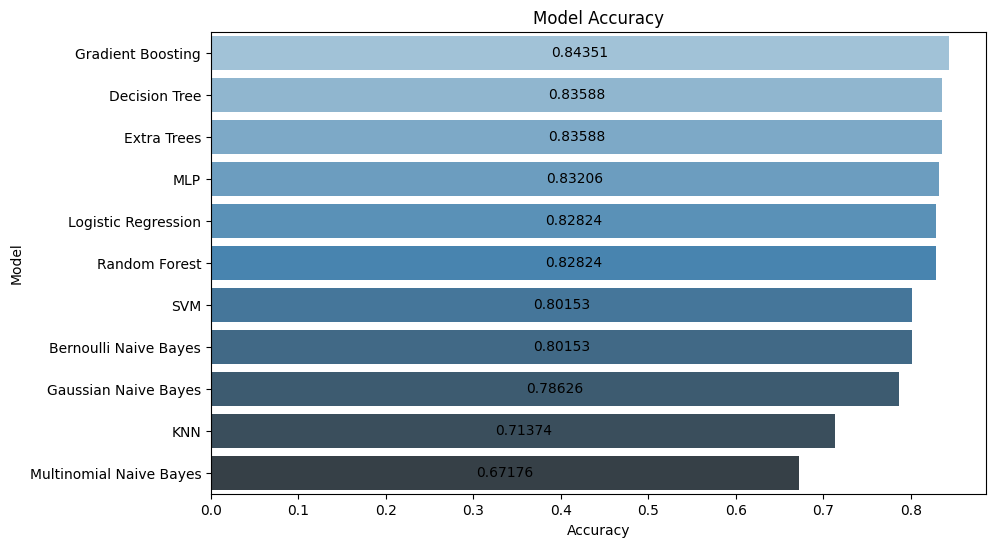

In [64]:
plt.figure(figsize=(10, 6))
barplot = sb.barplot(x='Accuracy', y='Model', hue='Model', data=results, palette='Blues_d', errorbar=None)

for p in barplot.patches:
    width = p.get_width()
    plt.text(width / 2,  
             p.get_y() + p.get_height() / 2,
             '{:1.5f}'.format(width),
             ha = 'center',
             va = 'center')

plt.title('Model Accuracy')
plt.xlabel('Accuracy')
plt.ylabel('Model')
plt.show()

The best models have all the metrics very close to each other, which is a good sign that the model is well balanced and is not overfitting the data. Looking at the final results, we cannot make a direct assumption of how the model will perform based in its complexity, as we have models like `Logistic Regression` that are simpler models and performed very well, and models like `K-Nearest Neighbors` that are more complex and didn't perform as well. Each model has its own characteristics and assumptions, and the dataset might fit better in some models than in others.

It's important to note that we cannot conclude a model is the best based only on the `Accuracy` metric, as it can be misleading. However, in this case, the `Precision`, `Recall` and `F1 Score` metrics are very similar to the `Accuracy` metric, so we can safely say that the `Gradient Boosting` model is the best performing model for this dataset.

Now to assess how accurate the Best model actually was, we displayed it's confusion matrix to better understand how it handled the testing data.

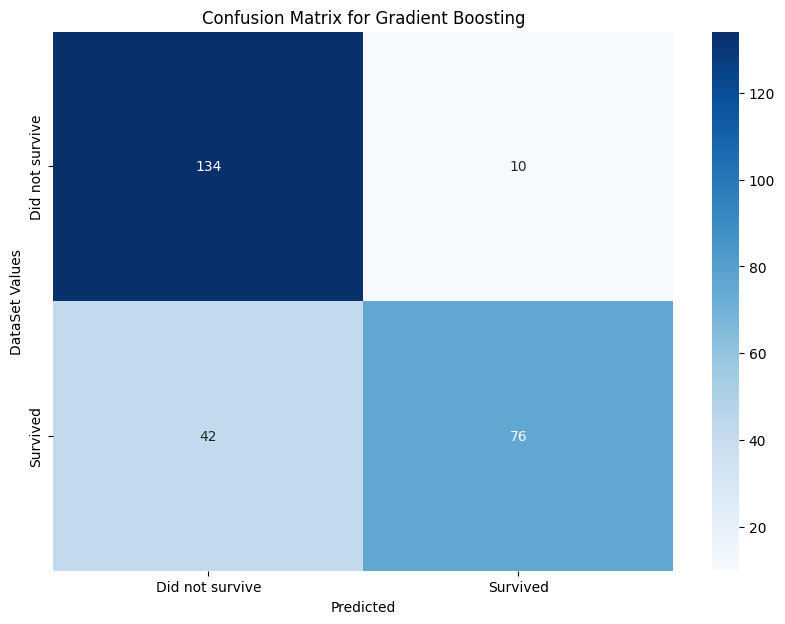

In [65]:
y_pred = best_model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sb.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Did not survive', 'Survived'], yticklabels=['Did not survive', 'Survived'])
plt.xlabel('Predicted')
plt.ylabel('DataSet Values')
plt.title(f'Confusion Matrix for {best_model_name}')
plt.show()

Here we can see that the model handled the cases of the non-survivors almost perfectly, having a very low rate of false-positives, leading to a good `Precision` score, indicating that this model could be used, for example, in order to find out the most affected areas of the ship or the characteristics of the passengers that could lead to a higher probability of not surviving.

On the other hand, we do see a pretty substantial number of false-negatives, more than half as much as the number of true-positives, also indicated by the lower `Recall` score, compared to the rest of the metrics. This indicates that the model, even being the best performer out of all of the ones we tested, still struggled to correctly predict the outcome of the true survivors of the Titanic. <br>
This can be due to the dataset having fewer survivors than non-survivors, therefore a bigger rate of non-survival, making it more unlikely that the model would predict a certain passenger surviving. Also, since there are fewer survivors, the common characteristics between them become more sparse, also making the model's job a lot harder.